In [138]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'
#%load_ext itikz

#%matplotlib widget
#import ipywidgets as widgets
#from ipywidgets import *
#from ipywidgets.embed import embed_minimal_html

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

## buffer

the simplest circuit to begin with is a voltage buffer. while buffers with opamps are relatively easy, with the cmos chips the input and output impedence are important. 

The gain of a cmos buffer is

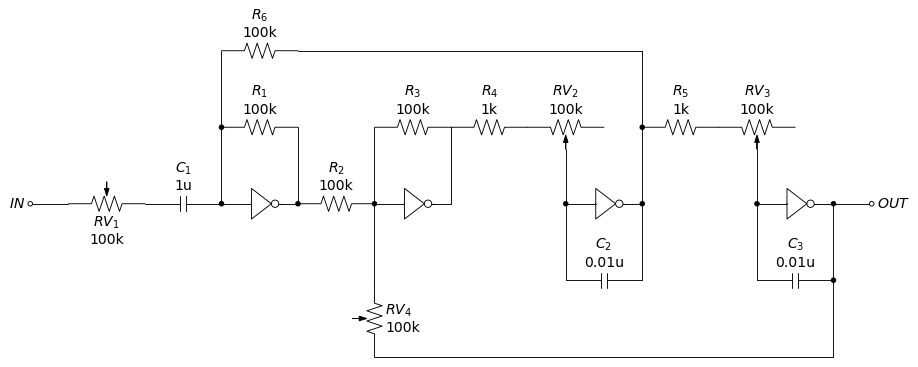

In [139]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)

d.add(elm.Dot(open=True, lftlabel='$IN$'))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Potentiometer(label="$RV_1$\n100k"))
d.add(elm.Capacitor(label="$C_1$\n1u"))
N1 = d.add(logic.Not)
d.add(elm.Resistor('right', label='$R_2$\n100k'))
N2 = d.add(logic.Not)
d.add(elm.Line('up', l=d.unit))
R3 = d.add(elm.Resistor('left', label='$R_3$\n100k'))
d.add(elm.Line('down', l=d.unit))
d.add(elm.Dot())

d.add(elm.Dot(at=N1.start))
d.add(elm.Line("up", l=d.unit))
R1 = d.add(elm.Resistor('right', label='$R_1$\n100k'))
d.add(elm.Line("down", l=d.unit))
d.add(elm.Dot())

d.add(elm.Resistor("right", at=R3.start, label='$R_4$\n1k'))
RV2 = d.add(elm.Potentiometer("right", toplabel="$RV_2$\n100k", flip=True))
d.add(elm.Line("down", toy=N1.end, at=RV2.tap))
N3 = d.add(logic.Not("right"))
d.add(elm.Line("up", l=d.unit))
R5 = d.add(elm.Resistor("right", label='$R_5$\n1k'))
RV3 = d.add(elm.Potentiometer("right", toplabel="$RV_3$\n100k", flip=True))
d.add(elm.Line("down", toy=N1.end, at=RV3.tap))
N4 = d.add(logic.Not("right"))
d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Dot(open=True, rgtlabel="$OUT$"))

d.add(elm.Dot(at=R5.start))
d.add(elm.Line("up", l=d.unit))
d.add(elm.Line("left", tox=R1.end))
d.add(elm.Resistor(label="$R_6$\n100k"))
d.add(elm.Line("down", l=d.unit))
d.add(elm.Dot())

d.add(elm.Dot(at=N3.start))
d.add(elm.Line("down"))
d.add(elm.Capacitor("right", label="$C_2$\n0.01u"))
d.add(elm.Line("up"))
d.add(elm.Dot())

d.add(elm.Dot(at=N4.start))
d.add(elm.Line("down"))
C3 = d.add(elm.Capacitor("right", label="$C_3$\n0.01u"))
d.add(elm.Line("up"))
d.add(elm.Dot())

d.add(elm.Dot(at=C3.end))
d.add(elm.Line("down"))
d.add(elm.Line("left", tox=N2.start))
d.add(elm.Potentiometer("up", label="$RV_4$\n100k"))
d.add(elm.Line("up", toy=N2.start))

d.draw()

In [140]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)
circuit.X('4', '4069UB', 'gate_in_4', 'gate_out_4', '+5V', circuit.gnd)

circuit.R("v1", 'IN', 'rv1_out', 100@u_kΩ)
circuit.C(1, 'rv1_out', 'gate_in_1', 1@u_uF)

circuit.R("1", 'gate_in_1', 'gate_out_1', 100@u_kΩ)
circuit.R("2", 'gate_out_1', 'gate_in_2', 100@u_kΩ)
circuit.R("3", 'gate_in_2', 'gate_out_2', 100@u_kΩ)
circuit.R("4", 'gate_out_2', 'R4out', 1@u_kΩ)
circuit.R("v2", 'R4out', 'gate_in_3', 50@u_kΩ)
circuit.R("5", 'gate_out_3', 'R5out', 1@u_kΩ)
circuit.R("v3", 'R5out', 'gate_in_4', 50@u_kΩ)

circuit.C(2, 'gate_in_3', 'gate_out_3', 0.01@u_uF)
circuit.C(3, 'gate_in_4', 'gate_out_4', 0.01@u_uF)

circuit.R("v4", 'gate_out_4', 'gate_in_2', 100@u_kΩ)
circuit.R(6, 'gate_out_3', 'gate_in_1', 100@u_kΩ)

print(circuit)


.title cmos buffer
.include /home/etienne/Documents/elektrophon/lib/spice/cmos/4069ub.lib
V1 +5V 0 DC 5
V2 IN 0 DC 5 AC 2.5V SIN(0 2.5V 1k)
X1 gate_in_1 gate_out_1 +5V 0 4069UB
X2 gate_in_2 gate_out_2 +5V 0 4069UB
X3 gate_in_3 gate_out_3 +5V 0 4069UB
X4 gate_in_4 gate_out_4 +5V 0 4069UB
Rv1 IN rv1_out 100kOhm
C1 rv1_out gate_in_1 1uF
R1 gate_in_1 gate_out_1 100kOhm
R2 gate_out_1 gate_in_2 100kOhm
R3 gate_in_2 gate_out_2 100kOhm
R4 gate_out_2 R4out 1kOhm
Rv2 R4out gate_in_3 50kOhm
R5 gate_out_3 R5out 1kOhm
Rv3 R5out gate_in_4 50kOhm
C2 gate_in_3 gate_out_3 0.01uF
C3 gate_in_4 gate_out_4 0.01uF
Rv4 gate_out_4 gate_in_2 100kOhm
R6 gate_out_3 gate_in_1 100kOhm



In [141]:
buffer_data_lp = []
for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
    circuit.Rv2.resistance = r
    circuit.Rv3.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms);
    buffer_data_lp.append(np.array(analysis_ac['gate_out_4']))

In [142]:
buffer_data_hp = []
for r in np.arange(0.001@u_kΩ, 110@u_kΩ, 20@u_kΩ):
    circuit.Rv2.resistance = r
    circuit.Rv3.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=22@u_kHz, number_of_points=10,  variation='dec')
    analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=1@u_ms);
    buffer_data_hp.append(np.array(analysis_ac['gate_out_1']))

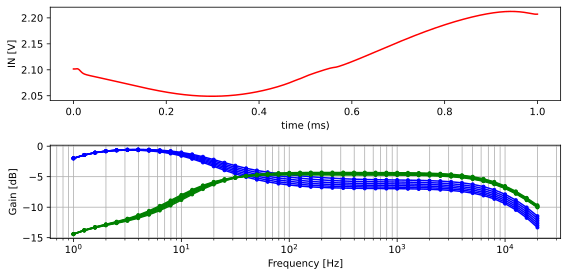

In [143]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(8, 4))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('IN [V]')
#ax1.plot(u_ms(analysis['OUT'].abscissa), analysis['OUT'], color='Red')
ax1.plot(u_ms(analysis['gate_out_4'].abscissa), analysis['gate_out_4'], color='Red')

for f in buffer_data_lp :
    bode_diagram_gain(axe=ax2,
                    frequency=analysis_ac.frequency,
                    gain=20*np.log10(np.absolute(f)),
                    marker='.',
                    color='blue',
                    linestyle='-',
    )
for f in buffer_data_hp :
    bode_diagram_gain(axe=ax2,
                    frequency=analysis_ac.frequency,
                    gain=20*np.log10(np.absolute(f)),
                    marker='.',
                    color='green',
                    linestyle='-',
    )

#ax2.axvline(x=freq, color='Red', linestyle='--')

plt.tight_layout()
plt.show()


## *references*

- [CD4069][1] Datasheet
